In [4]:
import numpy as np
import pandas as pd
import os,sys,inspect
import scipy.stats as stats
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.io import loadmat
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import itertools as it
import copy

# mine
# (1)
import demand_discrete_choice as dc1
import demand_discrete_choice.DiscreteChoice as dc

# (2)
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import myfunctions as mf

import importlib
importlib.reload(dc)
importlib.reload(mf)

<module 'myfunctions' from '/Users/jingyuanwang/GitHub/NU450_HW/myfunctions.py'>

In [5]:
#help(dc)

In [6]:
# ------------------------------------------------------------------------
# NOTE
# ------------------------------------------------------------------------
# Purpose: HW2 
# 
# Import data and stats
# 
#
# ------------------------------------------------------------------------

# Initialize file path

In [7]:
rootpath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-1-HW2'
datapath = rootpath + '/' + 'data'
resultpath = rootpath + '/' + 'results'

# Parameters
Everything should be input in the following cell. 
All other cells are just operation and calculation.

In [8]:
# model parameters (true value)
true_parameters = {'beta': np.array([5,1,1]),
                   'alpha_0': 1,
                   'alpha_sigma':1,
                   'gamma': np.array([2,1,1])}

# import file names
matfiles = ['10markets3products', '100markets3products','100markets5products']
names = ['m10_prod3', 'm100_prod3', 'm100_prod5']

# Import Data

In [9]:
# 1 import
inputfiles = dict(zip(names, matfiles))
data = {}
for name, filename in inputfiles.items():
    file = datapath + '/Simulation Data/'+ filename
    data[name] = loadmat(file)


In [16]:
# 2. clean and save to a class
num_of_market = 10
num_of_prod = 3
sample = 'm{}_prod{}'.format(num_of_market,num_of_prod)


df_product = (pd.DataFrame(np.concatenate( 
                          (data[sample]['x1'],
                           data[sample]['xi_all'],
                           data[sample]['w'], 
                           data[sample]['Z'],
                           data[sample]['eta']), axis = 1 ))
              .rename(columns = {0:'x1',1:'x2',2:'x3',3:'xi', 4:'w', 5:'z',6:'eta'}) )
df_product['price'] = np.reshape(data[sample]['P_opt'].T, (num_of_market*num_of_prod,1))
df_product['shares'] = np.reshape(data[sample]['shares'].T, (num_of_market*num_of_prod,1))

df_product['product_id'] = (np.repeat(np.arange(num_of_prod)[:,np.newaxis],num_of_market, axis = 1)
                            .reshape((num_of_prod*num_of_market,1), order = 'F') )

df_product['market_id'] = np.repeat(np.arange(num_of_market)[:, np.newaxis], num_of_prod, axis=0)
product_ids = {'market_id':'market_id',
               'product_id':'product_id'}


# consumer
df_consumer = pd.DataFrame(data[sample]['alphas'].T, columns=[idx for idx in range(num_of_market) ])
df_consumer = df_consumer.stack().reset_index().rename(columns = {'level_0':'consumer_id', 
                                                                  'level_1':'market_id',
                                                                  0:'alpha'})


consumer_ids = {'market_id':'market_id',
               'consumer_id':'consumer_id'}


In [17]:
# 3. fit it into a class: discrete choice

demand_m10_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, 
                                     df_product, product_ids, include_outside_option = True,
                                     true_parameters=true_parameters)


In [15]:
demand_m100_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, 
                                      df_product, product_ids, include_outside_option = True,
                                      true_parameters=true_parameters)


In [13]:

demand_m100_prod5 = dc.DiscreteChoice(df_consumer, consumer_ids, 
                                      df_product, product_ids, include_outside_option = True,
                                      true_parameters=true_parameters)


In [30]:
df_product.head()

,x1,x2,x3,xi,w,z,eta,price,shares,product_id,market_id
0,1.0,0.624347,0.462097,-0.892643,-0.410991,-0.782938,-0.027995,1.228510,0.127048,0,0
1,1.0,0.127053,-1.204106,-0.780327,-0.209172,0.883449,-0.721130,2.541496,0.001088,1,0
2,1.0,0.831763,2.557366,-0.068739,-1.045494,-0.547893,-1.003016,1.796136,0.770154,2,0
3,1.0,0.411836,1.876297,1.161735,-0.410991,-0.818453,-0.678975,1.139512,0.298087,0,1
4,1.0,0.802276,1.320284,-1.577227,-0.209172,-0.777962,-0.215393,1.425061,0.010210,1,1


# Q1. Simulate consumer choice and welfare

In [18]:
demand_sys = copy.deepcopy(demand_m100_prod3)
num_m = 100
num_prod = 3

## simulate

In [19]:
product_attribute_observed = ['x1','x2','x3']
product_attribute_unobs = 'xi'
eps = 'eps_ijm'
price = 'price'
taste = demand_sys.true_par['beta']
price_sensitivity = 'alpha'

demand_sys.simulate_consumer_choice(product_attribute_observed, product_attribute_unobs, price,
                                    taste, price_sensitivity, eps)


Total welfare = 900361.507623076


In [20]:
cost_attribute_observed = ['w', 'z']
cost_input_coeff = demand_sys.true_par['gamma']
error_term = 'eta'

demand_sys.simulate_firm_profit(cost_attribute_observed, price, cost_input_coeff, error_term)

Total Profits of each firm (product) = 
            total_profit
product_id              
0               0.000000
1           22879.082987
2            9170.349239
3           11120.829732


## Plot

In [21]:
path = resultpath + '/' + 'Q1'

1. price:

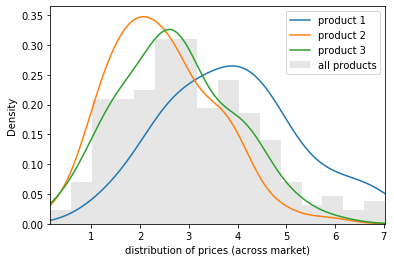

In [22]:
mf.hist_and_kdensity_bygroup(demand_sys.products[demand_sys.products['product_id']!= 0], 'price', 
                        var_label = 'distribution of prices (across market)', 
                        groupname = 'product_id', group_label = 'product',
                            save = True, figpath= path, figname = 'dist_price_m{}_prod{}'.format(num_m,num_prod))

2. firms' profits

--- Firm Sales ---


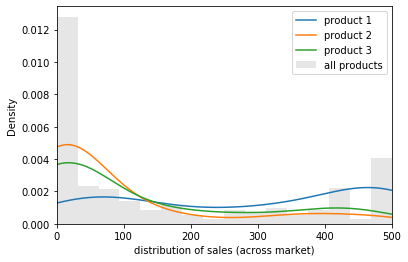

--- Firm Profits ---


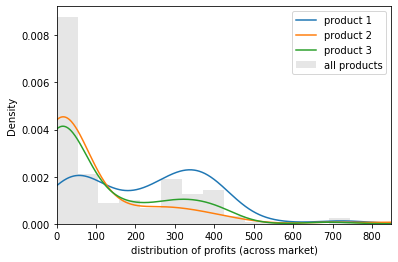

In [23]:
print('--- Firm Sales ---')
mf.hist_and_kdensity_bygroup(demand_sys.products[demand_sys.products['product_id']!= 0], 
                             'sales', 
                        var_label = 'distribution of sales (across market)', 
                        groupname = 'product_id', group_label = 'product')
print('--- Firm Profits ---')
mf.hist_and_kdensity_bygroup(demand_sys.products[demand_sys.products['product_id']!= 0], 
                             'profit_jm', 
                        var_label = 'distribution of profits (across market)', 
                        groupname = 'product_id', group_label = 'product',  
                             save = True, figpath= path, figname = 'dist_profit_m{}_prod{}'.format(num_m,num_prod))


3. utility and welfare

------ Welfare ------
Welfare distribution for all markets:


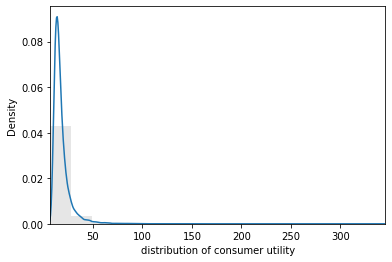

In [24]:
print('------ Welfare ------')
print('Welfare distribution for all markets:')
mf.hist_and_kdensity(demand_sys.consumers['utility'], var_label = 'distribution of consumer utility',
                     save = True, figpath= path, figname = 'dist_welfare_m{}_prod{}'.format(num_m,num_prod))

Welfare distribution in market 58:


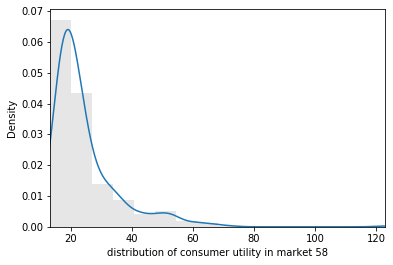

In [25]:
# one specific market
market = 58
print('Welfare distribution in market {}:'.format(market))
mf.hist_and_kdensity(demand_sys.consumers.loc[demand_sys.consumers['market_id']==market, 'utility'],
                      var_label = 'distribution of consumer utility in market {}'.format(market))

4. check whether the simulated choices match the given shares variable:

In [26]:
def plot_fit(yvar, xvar, ylabel = None, xlabel = None):

        # Figure parameters
        area = np.pi*3
        # Plot
        plt.figure()
        plt.scatter(xvar, yvar, s=area, alpha=0.5)
        plt.title('Scatter plot')
        if xlabel != None:
            plt.xlabel(xlabel)
        if ylabel != None:
            plt.ylabel(ylabel)
        plt.show()

In [27]:
df = demand_sys.products.copy()

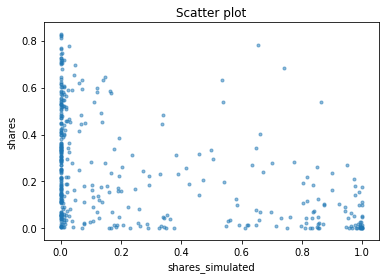

In [28]:
# check whether the given share and the share I got roughtly match
#df.sort_values(['market_id','product_id']).head(20)

plot_fit(df['shares'], df['sales']/500, ylabel = 'shares', xlabel = 'shares_simulated')

In [29]:
# check whether all consumers buy
df = df[ df['product_id']!=0 ]
stats.describe( df.groupby('market_id').agg({'sales':np.sum})['sales'] )

DescribeResult(nobs=100, minmax=(499, 500), mean=499.99, variance=0.009999999999999995, skewness=-9.849370589540557, kurtosis=95.01010101010475)

emm... >_< Not match at all ... and most consumer buys